In [ ]:
!pip install rasterio
!pip install geopandas

In [2]:
import numpy
from datetime import datetime
import os
import timeit
import csv
import time
import rasterio
import geopandas

In [3]:
# Cores
cores = !cat /proc/cpuinfo | sed -n -e 's/^cpu cores\t: //p'
cores = sum([int(i) for i in cores])
# CPU
cpu = !cat /proc/cpuinfo | grep 'model name'
family = !cat /proc/cpuinfo | grep 'cpu family'
model = !cat /proc/cpuinfo | grep 'model'
stepping = !cat /proc/cpuinfo | grep 'stepping'
machine = ' '.join([entry[0].split(': ')[1] for entry in (cpu,family,model,stepping)])
# bogomips
bogomips = !cat /proc/cpuinfo | grep 'bogomips'
bogomips = bogomips[0].split(': ')[1]
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu = False if len(devices)==1 else [x.physical_device_desc for x in devices if x.device_type == 'GPU'][0].split(', ')[1].split(': ')[1]

In [19]:
def downsampling_reader(ifile, factor, downMethod):
  from rasterio.enums import Resampling
  if downMethod in ('novel','random'):
    downscale_factor = 1
    ifile = os.path.splitext(ifile)[0] + '-df' + factor + '.' + os.path.splitext(ifile)[0]
    downMethod = 'nearest'
  else:
    downscale_factor = factor
  with rasterio.open(ifile) as dataset:
    # resample data to target shape
    ndDataset = dataset.read(
      out_shape=(
        dataset.count,
        int(dataset.height / downscale_factor),
        int(dataset.width / downscale_factor)
      ),
      resampling=Resampling[downMethod]
    )
    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
      (dataset.width // ndDataset.shape[-1]),
      (dataset.height // ndDataset.shape[-2])
    )
    icsv = os.path.splitext(ifile)[0]+'.shp'
    training = geopandas.read_file(icsv)
    training[training.columns[0:7]] = training[training.columns[0:7]].astype(numpy.int16)
    return (ndDataset,training,dataset.crs,transform)

def rf_wrapper(ndDataset, training):
  '''calculates bfastmonitor results with fixed parameters'''

  toPredict = ndDataset.reshape(7,ndDataset.shape[1]*ndDataset.shape[2]).transpose()
  

  features = training.filter(like='SR')
  labels = training.filter(like='discrete')

  #Import Random Forest Model
  from sklearn.ensemble import RandomForestClassifier
  print("lower")
  #Create a Gaussian Classifier
  print("features")
  print(features)
  print("labels")
  print(labels)
  clf = RandomForestClassifier(n_estimators = 100).fit(features,labels)
  print("upper")
  classified = clf.predict(toPredict).transpose().reshape(ndDataset.shape[1],ndDataset.shape[2])
  return classified

def result_writer(classified,ifile,factor,downMethod,crs,transform,experiment):
  #print("done calculating. Now exporting and stuff..")
  dirName = os.path.dirname(ifile)
  basename = os.path.basename(ifile)
  niceId = basename.split('-')[0]
  exportName = '.'.join(('-'.join((niceId,'bfastmonitor',downMethod,str(factor),experiment)),'tif'))
  exportName = os.path.join(dirName,exportName)

  classified_dataset = rasterio.open(
    exportName,
    'w',
    driver='GTiff',
    height=classified.shape[0],
    width=classified.shape[1],
    count=1,
    dtype=classified.dtype,
    crs=crs,
    transform=transform
    )
  classified_dataset.write(frac_breaks,1)
  #print("done even exporting. Donno whatchu waitin fo")
  return breaks_dataset.close()

In [11]:
ifile = '/content/drive/MyDrive/Paper1-ml/woodside-CLBS-1000-4526_5-2250_5-EPSG32612-2019-07-01-2019-10-01-classYear2019-maxCloud1.tif'

In [12]:
nd,training,crs,transform = downsampling_reader(ifile,1,'nearest')


In [7]:
training.filter(like='SR')

SR_B1  SR_B2  SR_B3  SR_B4  SR_B5  SR_B6  SR_B7
0     9703  10263  11717  12521  16417  17733  15537
1     9964  10502  12216  13982  17557  19951  18667
2    11026  11832  14309  15291  17742  19937  16817
3    11183  12368  14315  15505  19191  21977  20016
4    11360  12194  14156  15084  17145  21017  18985
..     ...    ...    ...    ...    ...    ...    ...
935   9197   9581  10569  10922  14751  15562  13515
936   9835  10338  11410  11980  15747  17284  15022
937   9503   9882  11162  12224  16116  17104  15642
938   9773  10232  11311  11884  15596  17269  15070
939   9519  10037  11111  11645  15685  16020  14010

[940 rows x 7 columns]

In [8]:
training.filter(like='SR')

SR_B1  SR_B2  SR_B3  SR_B4  SR_B5  SR_B6  SR_B7
0     9703  10263  11717  12521  16417  17733  15537
1     9964  10502  12216  13982  17557  19951  18667
2    11026  11832  14309  15291  17742  19937  16817
3    11183  12368  14315  15505  19191  21977  20016
4    11360  12194  14156  15084  17145  21017  18985
..     ...    ...    ...    ...    ...    ...    ...
935   9197   9581  10569  10922  14751  15562  13515
936   9835  10338  11410  11980  15747  17284  15022
937   9503   9882  11162  12224  16116  17104  15642
938   9773  10232  11311  11884  15596  17269  15070
939   9519  10037  11111  11645  15685  16020  14010

[940 rows x 7 columns]

lower
features
     SR_B1  SR_B2  SR_B3  SR_B4  SR_B5  SR_B6  SR_B7
0     9703  10263  11717  12521  16417  17733  15537
1     9964  10502  12216  13982  17557  19951  18667
2    11026  11832  14309  15291  17742  19937  16817
3    11183  12368  14315  15505  19191  21977  20016
4    11360  12194  14156  15084  17145  21017  18985
..     ...    ...    ...    ...    ...    ...    ...
935   9197   9581  10569  10922  14751  15562  13515
936   9835  10338  11410  11980  15747  17284  15022
937   9503   9882  11162  12224  16116  17104  15642
938   9773  10232  11311  11884  15596  17269  15070
939   9519  10037  11111  11645  15685  16020  14010

[940 rows x 7 columns]
labels
     discrete_c
0            20
1            20
2            20
3            20
4            20
..          ...
935         126
936         126
937         126
938         126
939         126

[940 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


upper


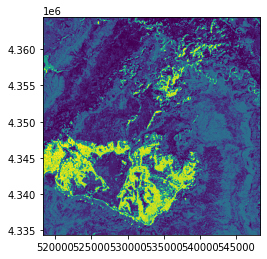

In [20]:
from rasterio.plot import show
test = rf_wrapper(nd,training)
show(test,transform=transform)

In [ ]:
type(test[1,1])

numpy.int64

In [ ]:
from rasterio.plot import show
show(predicted.astype(numpy.float32),transform=transform)